In [ ]:
!pip install pretty_midi
!pip install tensorflow
!pip install mido
import pretty_midi
import numpy as np
from IPython.display import clear_output
import os
import tensorflow as tf
import keras.models
import keras.layers
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from mido import Message, MidiFile, MidiTrack, MetaMessage
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
clear_output()

In [ ]:
!unzip /content/midi_files.zip
data_path = []
# Import only relevant midi 4/4 files 
for song_name in os.listdir(os.path.join('/content/midi_files')):
    data_path.append(os.path.join('/content/midi_files', song_name))
num_songs = len(data_path)

clear_output()

In [ ]:
print(num_songs)

21


In [ ]:
#making synthetic data
data = np.array([[1, 0, 0, 1, 0, 0]]*5)
data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
data = np.append(data, np.array([[0, 0, 0, 1, 0 ,0]]*5), axis=0)
data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
data = np.append(data, np.array([[0, 1, 0, 1, 0, 0]]*5), axis=0)
data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
data = np.append(data, np.array([[0, 0, 0, 1, 0 ,0]]*5), axis=0)
data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
for i in range(300):
  data = np.append(data, np.array([[1, 0, 0, 1, 0, 0]]*5), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 1, 0 ,0]]*5), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
  data = np.append(data, np.array([[0, 1, 0, 1, 0, 0]]*5), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 1, 0 ,0]]*5), axis=0)
  data = np.append(data, np.array([[0, 0, 0, 0, 0 ,1]]*3), axis=0)

In [ ]:
''''
#drums = [35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 51, 52]
35 Acoustic bass drum
36 Bass drum
37 Snare side stick
38 Snare
40 Electric snare
41 Low floor tom 
42 Hi-hat closed 
43 High floor tom
45 Low tom 
46 Hi-hat open 
49 Crash cymbal 
51 Ride cymbal 
52 Chinese cymbal
'''
# [kick, snare, tom, closed hi-hat, crash, 'silence']
# output_drums = [36, 38, 43, 42, 49, None]
num_drums = 6

def drum2idx(drum):
  if (drum == 35 or drum ==36): 
    return 0
  if (drum == 37 or drum == 38 or drum == 40): 
    return 1
  if (drum == 41 or drum == 43 or drum == 45): 
    return 2
  if (drum == 42 or drum == 46):
    return 3
  if (drum == 49 or drum == 51 or drum == 52): 
    return 4

def idx2drum(idx):
  output_drums = [36, 38, 43, 42, 49, None]
  return output_drums(idx)


def process(data_path):
  data = {}
  for i in range(len(data_path)):
    data[i] = pretty_midi.PrettyMIDI(data_path[i])
  midi_processed = {}
  for i in range(len(data_path)):
    midi_list = []
    #Iterate through all instruments (only the drum in these files)
    for instrument in data[i].instruments:
      for note in instrument.notes: 
        #Convert the start and end time to tick number. 
        start = data[i].time_to_tick(note.start)
        end = data[i].time_to_tick(note.end)
        pitch = drum2idx(note.pitch)
      
        # volume goes from 1 to 127
        volume = (note.velocity)
        midi_list.append([start, end, pitch, volume])
    midi_processed[i] = np.array(midi_list)
  return midi_processed

def findNotesAtBeats(tick, song):
  line = np.zeros(num_drums, dtype='int')
  silence = True
  for note in song:
    if tick >= note[0] and tick <= note[1]:
      line[note[2]] = 1
      silence = False
  if silence:
    line[num_drums-1] = 1
  return line

# Processed array for each song where each line represents 1/16th of a beat (~0.03125 sec)
def compress(midi_processed):
  midi = {}
  #for i in midi_processed:
  for i in midi_processed:
    song = midi_processed[i]
    new = []
    for beat in range(0, midi_processed[i][-1,1],30):
      new.append(findNotesAtBeats(beat, song))
    midi[i] = np.array(new)
  return midi


midi_processed = process(data_path)
midi = compress(midi_processed)
clear_output()

In [ ]:
print(input[0])
train_data = np.array(midi, dtype="int")

# Putting all songs after each other in a big 2D array

In [ ]:
def get_length_all_songs(num_songs):
  length_all_songs = 0
  for x in range(0, num_songs):
    length_all_songs += len(midi[x])
  return length_all_songs

def get_train_data(midi, num_drums, length_all_songs):
  train_data = np.zeros([length_all_songs, num_drums], dtype="int")
  i = 0
  for x in range(0, len(midi)):
    for c in range(0, len(midi[x])):
      train_data[i] = midi[x][c]
      i+=1
  return train_data

length_all_songs = get_length_all_songs(num_songs)
train_data = get_train_data(midi, num_drums, length_all_songs)
print(train_data[3])
print(train_data.shape)

[1 0 0 1 0 0]
(15313, 6)


# Getting the data into the right shape for training / testing

In [ ]:
time_steps = 128
num_drums = num_drums
#this is the number of future vectors that are predicted
num_future_vector = 4
length_all_songs = len(train_data)
#length of the output vector of the network
future_pred = num_drums * num_future_vector
cut = int(len(train_data)*0.8)
num_samples = int(cut/time_steps)
trainX = np.zeros([num_samples, time_steps, num_drums], dtype = "int")
trainY = np.zeros([num_samples, future_pred], dtype = "int")
tick = 0
for idx in range(0,num_samples):
  for step in range(0,time_steps):
    trainX[idx][step] = train_data[tick]
    tick += 1
  for i in range(0,num_future_vector):
    if i == 0:
      dummy = train_data[tick]
    else:
      dummy  = np.append(dummy, train_data[tick])
    tick += 1
  trainY[idx] = dummy
  dummy = []
  if tick > cut - time_steps - num_future_vector:
    break
num_samples = int((length_all_songs - cut) /time_steps)
testX = np.zeros([num_samples, time_steps, num_drums], dtype = "int")
testY = np.zeros([num_samples, future_pred], dtype = "int")
tick = cut
for idx in range(0,num_samples):
  for step in range(0,time_steps):
    testX[idx][step] = train_data[tick]
    tick += 1
  for i in range(0, num_future_vector):
    if i == 0:
      dummy = train_data[tick]
    else:
      dummy  = np.append(dummy, train_data[tick])
    tick += 1
  testY[idx] = dummy
  dummy = []
  if tick > length_all_songs - time_steps - num_future_vector:
    break
print(trainX.shape)
print(trainY.shape)
#print(trainX[3])
#print(trainY[3])
print(testX.shape)
print(testY.shape)

(95, 128, 6)
(95, 24)
(23, 128, 6)
(23, 24)


In [ ]:
print(trainX[10])

# Model and training

rerun when you change parameter above

In [ ]:
print(len(trainY))

133


In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((trainX.astype('float32'), trainY.astype('float32'))).shuffle((len(trainY))).batch(len(trainY))
dataset_test = tf.data.Dataset.from_tensor_slices((testX.astype('float32'), testY.astype('float32'))).shuffle((len(testY))).batch(len(testY))

In [ ]:
class DENSE_model(tf.keras.Model):
  def __init__(self):
    super(DENSE_model, self).__init__()
    self.layersNetwork = tf.keras.models.Sequential([
                                             tf.keras.layers.Flatten(),
                                             #tf.keras.layers.Dense(500, activation='relu'),
                                             tf.keras.layers.Dense(1000, activation='relu'),
                                             tf.keras.layers.Dense(700, activation='relu'),
                                             tf.keras.layers.Dense(500, activation='relu'),
                                             tf.keras.layers.Dense(300, activation='relu'),
                                             tf.keras.layers.Dense(100, activation='relu'),
                                             tf.keras.layers.Dense(future_pred, activation='softmax'),
    ])
    
  def run(self, input):
    output = self.layersNetwork(input)
    return output


In [ ]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
def caclulate_loss(Model, x, y):
  output = Model.run(input = x)

  loss = tf.keras.losses.categorical_crossentropy(y, output)
  return loss

In [ ]:
def train_step(Model, x, y, optimizer):
  with tf.GradientTape() as tape:
    loss = caclulate_loss(Model, x, y)
    gradients = tape.gradient(loss, Model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
    train_loss(loss)
def test_step(Model, x, y):
  loss = caclulate_loss(Model, x, y)
  test_loss(loss)

In [ ]:
def train_dataset(Model, dataset_train, dataset_test, epochs):
  loss_train = []
  loss_test = []
  epoch_number = []
  for epoch in range(epochs):
    print(epoch)
    for train_x, train_y in dataset_train:
      train_step(Model, train_x, train_y, optimizer)

    for test_x, test_y in dataset_test:
      test_step(Model, test_x, test_y)

    clear_output()
    loss_train.append(train_loss.result())
    loss_test.append(test_loss.result())
    epoch_number.append(epoch)
    plt.plot(epoch_number, loss_train, loss_test)
    plt.legend(['train', 'test'])
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

In [ ]:
Mymodel = DENSE_model()

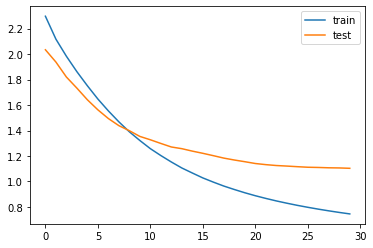

In [ ]:
train_dataset(Mymodel, dataset_train, dataset_test, 30)

# Generation
Generates output by running the network / always adding predicted elements to the sequence and then generating new predictions based on the sequence with added elements

In [ ]:
#testing the network / getting predictions
from numpy.random import uniform
generated_sequence = np.zeros([1,time_steps,num_drums], dtype = "int")
vector_for_tick = np.zeros(num_drums,dtype ="int")
output_length = 300
output = np.zeros([1, num_drums], dtype = 'int')
#let generated sequence be some time_steps long sequence/this sequence is used to start the generating process
generated_sequence[0] = trainX[10]
for c in range(0, output_length):
  prediction = Mymodel.run(generated_sequence)
  #print(prediction)

  #shift generated sequence back by how many future vectors are predicted so that the generated once can be added
  for i in range(0,time_steps-num_future_vector):
    generated_sequence[0][i] = generated_sequence[0][i+num_future_vector]
  #This code always takes the probabilities in prediction and converts it to vectors which are then added
  #to the generated_sequence and output
  counter = 0
  sequence_idx = 0
  for idx in range(0,future_pred):
    #depending on how many future vectors you predict you need to change the threshold
    #good way of doing it is looking at the probabilities in predction and checking what 
    #value makes sense
    threshold = 0.4
    if prediction[0][idx] > threshold:
      vector_for_tick[counter] = 1
    else:
      vector_for_tick[counter] = 0
    counter += 1
    #everytime the end of one vector of length num_drums is reached add that vector to generated_sequence
    #so that it is used to predict next predicition
    #also append that vector to output and after doing that reset the vector to all 0
    if counter == num_drums:
      generated_sequence[0][(time_steps - num_future_vector) + sequence_idx] = vector_for_tick
      #print(generated_sequence)
      sequence_idx += 1
      output = np.append(output, [vector_for_tick], axis=0)
      vector_for_tick.fill(0)
      counter = 0
print(output)


In [ ]:
#cell if wanna check how the training data actually sounds like
output = trainX[10]

# Constructing midi files based on output array

In [ ]:

def t2notes(t):
    drums = [36, 38, 43, 42, 49, None] #note numbers for the drums
    notes = []
    for i in range (num_drums-1): #-1 because the last index doesn't represent a drum
        if t[i] == 1:
            notes.append(drums[i])
    #notes will be empty if there's silence
    return notes

def constructMidi(output, tickTime):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(MetaMessage('set_tempo', tempo=468750))
    track.append(MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track.append(MetaMessage('key_signature', key='C', time=0))
    track.append(Message('program_change', channel=9, program = 0, time=0))
    counter = 0 #to add up equal timeframes to one beat instead of multiple equal drums
    ts = output[0]
    for t in output:
        #print(t)
        if (t == ts).all():
            counter += tickTime
            ts = t
        else:
            notes = t2notes(ts)
            for note in notes:
              track.append(Message('note_on', channel=9, note=note, velocity=64, time=0))
            track.append(Message('note_on', channel=9, note=1, velocity=0, time=counter))
            for note in notes:
              track.append(Message('note_on', channel=9, note=note, velocity=0, time=0))
            #print(notes)
            counter = tickTime
            ts = t
    notes = t2notes(ts)
    for note in notes:
      track.append(Message('note_on', channel=9, note=note, velocity=64, time=0))
    track.append(Message('note_on', channel=9, note=1, velocity=0, time=counter))
    for note in notes:
      track.append(Message('note_on', channel=9, note=note, velocity=0, time=0))
    mid.save('output.mid')
  
constructMidi(output, 31) #call this to convert output tensor to midi file, and specify ms per tick